In [ ]:
import pandas as pd
import numpy as np
import optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_recall_curve, roc_auc_score, roc_curve,
                             precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, classification_report, average_precision_score)
import warnings

warnings.filterwarnings('ignore')

try:
    # Các tệp này là kết quả từ các bước tiền xử lý trước
    train_df = pd.read_csv(r'C:\Users\DatGo\OneDrive\Documents\Personal_Project\Home_Credit_Default_Risk\application_train_features.csv')
    test_df = pd.read_csv(r'C:\Users\DatGo\OneDrive\Documents\Personal_Project\Home_Credit_Default_Risk\application_test_features.csv')
    print("Tải dữ liệu thành công!")
    print(f"Kích thước tập train: {train_df.shape}")
    print(f"Kích thước tập test: {test_df.shape}")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp cleaned. Vui lòng chạy các bước tiền xử lý và lưu file trước.")
    exit()

Tải dữ liệu thành công!
Kích thước tập train: (307511, 133)
Kích thước tập test: (48744, 132)


In [69]:
# --- Chuẩn bị dữ liệu ---
y = train_df['TARGET']
train_ids = train_df['SK_ID_CURR']
test_ids = test_df['SK_ID_CURR']

X = train_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
X_test = test_df.drop('SK_ID_CURR', axis=1)

# Mã hóa, căn chỉnh cột
X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
common_cols = list(set(X.columns) & set(X_test.columns))
X = X[common_cols]
X_test = X_test[common_cols]

# Dọn dẹp infinity và NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
median_values = X.median()
X.fillna(median_values, inplace=True)
X_test.fillna(median_values, inplace=True)

# Tách dữ liệu
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Chuẩn bị dữ liệu hoàn tất.")

Chuẩn bị dữ liệu hoàn tất.


In [ ]:
# --- Mô hình A: Logistic Regression ---
print("\n...Huấn luyện mô hình Baseline (Logistic Regression)...")
log_reg = LogisticRegression(C=0.0001, random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)
val_probs_lr = log_reg.predict_proba(X_val_scaled)[:, 1]
auc_lr = roc_auc_score(y_val, val_probs_lr)
print(f"==> Điểm AUC của Logistic Regression: {auc_lr:.5f}")
val_preds_lr_labels = (val_probs_lr >= 0.5).astype(int)
print("--- Báo cáo Phân loại (Classification Report) cho Logistic Regression ---")
print(classification_report(y_val, val_preds_lr_labels, target_names=['Repayer (0)', 'Defaulter (1)']))



...Huấn luyện mô hình Baseline (Logistic Regression)...
==> 🎯 Điểm AUC của Logistic Regression: 0.75680
--- Báo cáo Phân loại (Classification Report) cho Logistic Regression ---
               precision    recall  f1-score   support

  Repayer (0)       0.96      0.70      0.81     56538
Defaulter (1)       0.17      0.68      0.27      4965

     accuracy                           0.70     61503
    macro avg       0.56      0.69      0.54     61503
 weighted avg       0.90      0.70      0.76     61503



In [70]:
# ---------- Stratified K-Fold + hyperparams LightGBM (reduce overfitting) ----------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Các tham số cơ sở LightGBM được điều chỉnh để giảm tình trạng overfitting
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,   # nhỏ để ổn định
    'num_leaves': 31,        # không quá lớn
    'max_depth': 7,
    'min_data_in_leaf': 100, # tránh lá quá ít (giảm overfit)
    'feature_fraction': 0.8, # chọn subset feature mỗi iter
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': -1,
    'seed': 42
}

# Nếu imbalance nặng, set scale_pos_weight:
neg = (y_train==0).sum()
pos = (y_train==1).sum()
lgb_params['scale_pos_weight'] = neg/pos

In [ ]:
# Hàm để train LGB theo K-fold và trả về prediction_probs cho validation folds
def lgb_cv_predict_proba(X, y, params, skf, use_smote=False, n_rounds=10000):
    oof_preds = np.zeros(len(y))
    models = []
    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]
        # SMOTE on train only
        if use_smote:
            sm = SMOTE(random_state=42)
            X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)
        else:
            X_tr_res, y_tr_res = X_tr, y_tr

        dtrain = lgb.Dataset(X_tr_res, label=y_tr_res)
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
        model = lgb.train(
            params,
            dtrain,
            num_boost_round=2000,
            valid_sets=[dtrain, dval],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        preds = model.predict(X_val, num_iteration=model.best_iteration)
        oof_preds[val_idx] = preds
        models.append(model)
        print(f"Fold {fold+1} done. Best iter: {model.best_iteration}")
    return oof_preds, models

# Chuẩn hóa tên các feature để tránh lỗi JSON của LightGBM
def sanitize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
    )
    return df

X_train_sanitized = sanitize_columns(X_train.reset_index(drop=True))

# Chạy CV 
oof_preds_lgb, lgb_models = lgb_cv_predict_proba(
    X_train_sanitized,
    y_train.reset_index(drop=True).values,
    lgb_params, skf,
    use_smote=True
)

# Metrics trên out-of-fold
print("AUC (oof):", roc_auc_score(y_train, oof_preds_lgb))
print("Average precision (PR AUC):", average_precision_score(y_train, oof_preds_lgb))

Fold 1 done. Best iter: 1080
Fold 2 done. Best iter: 1227
Fold 3 done. Best iter: 1045
Fold 4 done. Best iter: 1190
Fold 5 done. Best iter: 1417
AUC (oof): 0.7661326452509306
Average precision (PR AUC): 0.2488853141300409


Best threshold (F1): 0.648, precision=0.244, recall=0.438, f1=0.313


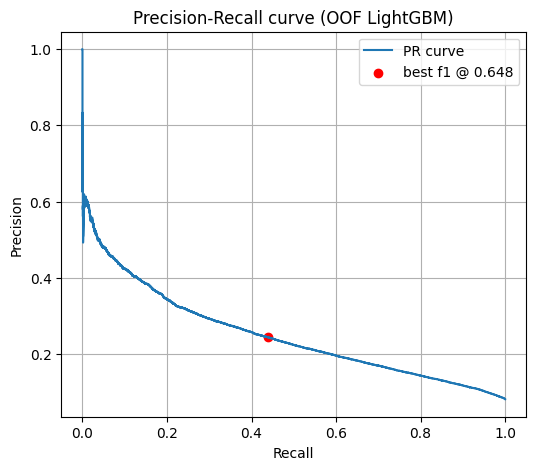

Validation classification report:
              precision    recall  f1-score   support

           0     0.9478    0.8858    0.9158     56538
           1     0.2547    0.4443    0.3238      4965

    accuracy                         0.8502     61503
   macro avg     0.6012    0.6651    0.6198     61503
weighted avg     0.8918    0.8502    0.8680     61503



In [ ]:
# ------- TÌM THRESHOLD TỐI ƯU  -------------
def find_best_threshold(y_true, probs, metric='f1'):
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    if metric == 'f1':
        ix = np.nanargmax(f1s)
        return thresholds[ix], precisions[ix], recalls[ix], f1s[ix]
    elif metric == 'balanced_accuracy':
        # Tính toán với nhiều ngưỡng khác nhau bằng cách sử dụng ma trận nhầm lẫn (confusion matrix).
        best = (0.0, 0.0, 0.0, 0.0)
        for t in np.linspace(0.01, 0.99, 99):
            y_pred = (probs >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            recall0 = tn/(tn+fp) if (tn+fp)>0 else 0
            recall1 = tp/(tp+fn) if (tp+fn)>0 else 0
            bal = (recall0 + recall1)/2
            if bal > best[0]:
                best = (bal, t, recall0, recall1)
        return best[1], best[2], best[3], best[0]
    else:
        raise ValueError("metric must be 'f1' or 'balanced_accuracy'")

best_t, best_prec, best_rec, best_f1 = find_best_threshold(y_train.values, oof_preds_lgb, metric='f1')
print(f"Best threshold (F1): {best_t:.3f}, precision={best_prec:.3f}, recall={best_rec:.3f}, f1={best_f1:.3f}")

# Vẽ PR curve & mark threshold
precisions, recalls, thresholds = precision_recall_curve(y_train.values, oof_preds_lgb)
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, label='PR curve')
plt.scatter([best_rec],[best_prec], color='red', label=f'best f1 @ {best_t:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (OOF LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

# -------- EVALUATE trên tập val sử dụng best threshold ----------
# Lấy trung bình dự đoán từ tất cả các mô hình LightGBM trên tập X_val.
val_probs = np.mean([m.predict(X_val, num_iteration=m.best_iteration) for m in lgb_models], axis=0)
y_pred_val = (val_probs >= best_t).astype(int)

print("Validation classification report:")
print(classification_report(y_val, y_pred_val, digits=4))


In [ ]:
# ---------- STACKING: LightGBM + XGBoost ----------
# Huấn luyện các mô hình cơ sở (base learners) trên toàn bộ tập huấn luyện (hoặc thông qua Cross-Validation), rồi chồng (stack) chúng lại bằng Logistic Regression.
# Chúng ta sẽ xây dựng các lớp bao bọc (wrapper) tương thích với sklearn cho LightGBM và XGBoost.
from sklearn.base import BaseEstimator, ClassifierMixin

class LGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n_estimators=1000):
        self.params = params or {}
        self.n_estimators = n_estimators
        self.model = None
    def fit(self, X, y):
        dtrain = lgb.Dataset(X, label=y)
        self.model = lgb.train(
            self.params,
            dtrain,
            num_boost_round=self.n_estimators,
            callbacks=[lgb.log_evaluation(0)]
        )
        # Thiết lập thuộc tính classes_ để tương thích với sklearn.
        self.classes_ = np.unique(y)
        return self
    def predict_proba(self, X):
        return np.vstack([1-self.model.predict(X), self.model.predict(X)]).T
    def predict(self, X):
        return (self.model.predict(X) >= 0.5).astype(int)

class XGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n_estimators=100):
        self.params = params or {}
        self.n_estimators = n_estimators
        self.model = xgb.XGBClassifier(**self.params, n_estimators=self.n_estimators, use_label_encoder=False, eval_metric='auc')
    def fit(self, X, y):
        self.model.fit(X, y, verbose=False)
        self.classes_ = np.unique(y)
        return self
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    def predict(self, X):
        return self.model.predict(X)

# Các tham số của XGBoost
xgb_params = {
    'learning_rate': 0.03,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42
}

lgb_wrapper = LGBWrapper(params=lgb_params, n_estimators=500)
xgb_wrapper = XGBWrapper(params=xgb_params, n_estimators=500)

estimators = [
    ('lgb', lgb_wrapper),
    ('xgb', xgb_wrapper)
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=skf,
    n_jobs=-1,
    passthrough=False
)

# Tùy chọn thêm bước chuẩn hóa (scaling) hoặc SMOTE vào pipeline cho mô hình stacker.
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('stack', stack_clf)
])

# Huấn luyện mô hình stacking trên toàn bộ tập dữ liệu huấn luyện
pipe.fit(X_train, y_train)

# Dự đoán trên tập dữ liệu kiểm thử (test set)
stack_probs = pipe.predict_proba(X_test)[:,1]
# Tìm ngưỡng dự đoán tối ưu trên tập validation (trước đó ta dùng OOF; nhưng ta cũng có thể tính ngưỡng trên OOF của train bằng cross_val_predict)
oof_stack = cross_val_predict(pipe, X_train, y_train, cv=skf, method='predict_proba', n_jobs=-1)[:,1]
best_t_stack, bp, br, bf = find_best_threshold(y_train.values, oof_stack, metric='f1')
print("Stack best threshold (F1):", best_t_stack, "f1:", bf)
val_stack_probs = pipe.predict_proba(X_val)[:,1]
y_pred_stack_val = (val_stack_probs >= best_t_stack).astype(int)

# In báo cáo cho tập validation
print("Stacking classification report (validation):")
print(classification_report(y_val, y_pred_stack_val, digits=4))
print("Stack ROC AUC (validation):", roc_auc_score(y_val, val_stack_probs))

# ---------- Độ ổn định của Cross-Validation ----------
# Hiển thị độ biến động của các chỉ số đánh giá giữa các fold cho LightGBM
fold_f1s = []
for tr_idx, val_idx in skf.split(X_train, y_train):
    y_true = y_train.iloc[val_idx].values
    yprob = oof_preds_lgb[val_idx]
    _, _, _, f1_val = find_best_threshold(y_true, yprob, metric='f1')
    fold_f1s.append(f1_val)
print("LGB fold F1s:", fold_f1s)
print("mean f1:", np.mean(fold_f1s), "std:", np.std(fold_f1s))

Stack best threshold (F1): 0.16831401844086383 f1: 0.32099477244725244
Stacking classification report (validation):
              precision    recall  f1-score   support

           0     0.9471    0.8950    0.9203     56538
           1     0.2649    0.4310    0.3281      4965

    accuracy                         0.8575     61503
   macro avg     0.6060    0.6630    0.6242     61503
weighted avg     0.8920    0.8575    0.8725     61503

Stack ROC AUC (validation): 0.7762914421966179
LGB fold F1s: [0.31445219218598436, 0.31589691247722546, 0.319868890388036, 0.3153294301966404, 0.3094403939016233]
mean f1: 0.3149975638299019 std: 0.0033415072513029442


Đang tạo dữ liệu nền cho SHAP explainer...
Đang khởi tạo SHAP KernelExplainer...
Đang tính toán giá trị SHAP trên tập validation... (Vui lòng chờ)


  0%|          | 0/100 [00:00<?, ?it/s]

Đang tạo biểu đồ SHAP summary plot...
SHAP values shape: (100, 228, 2)
X_val_sample shape: (100, 228)


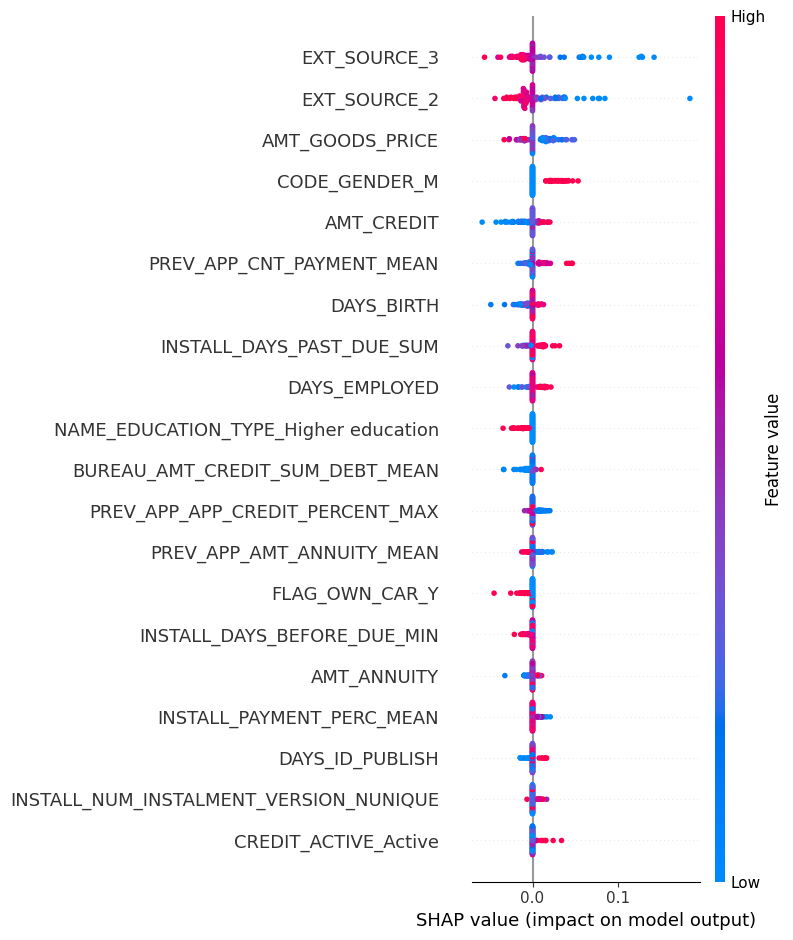

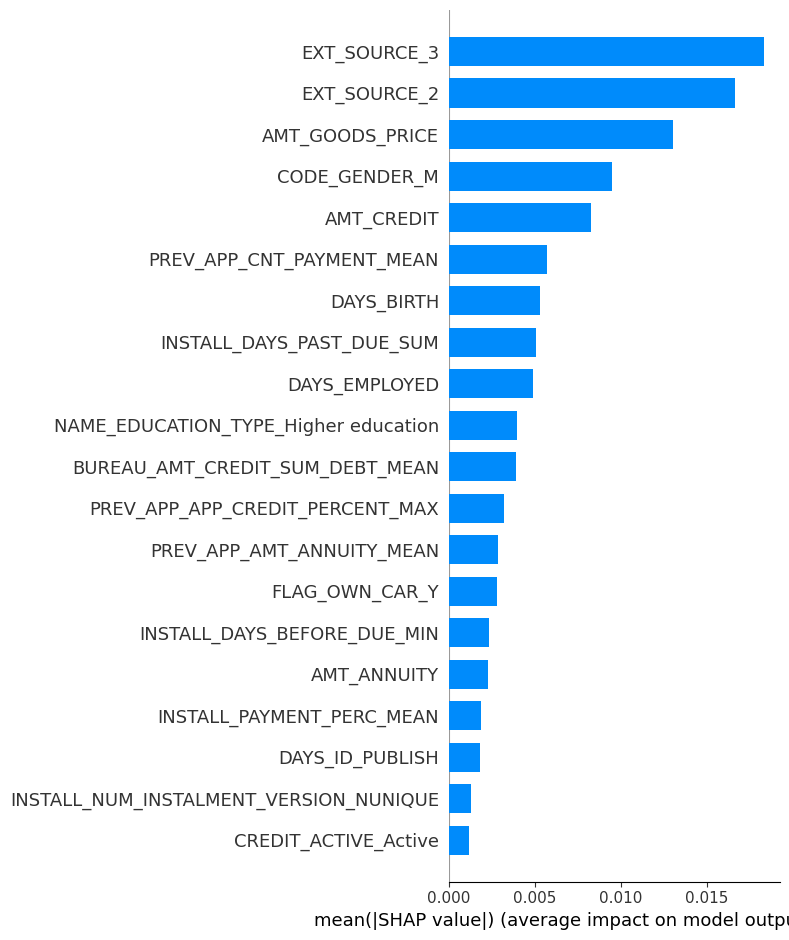

In [ ]:
# KernelExplainer cần một tập dữ liệu nền để tính toán giá trị kỳ vọng của mô hình.
# Ta dùng thuật toán K-Means để tóm tắt tập X_train thành 50 điểm dữ liệu đại diện.
print("Đang tạo dữ liệu nền cho SHAP explainer...")
background_data = shap.kmeans(X_train, 50)

# Tạo hàm wrapper để tránh lỗi với feature names
def model_predict(X):
	"""Wrapper function for pipeline prediction"""
	if hasattr(X, 'values'):
		X = X.values
	return pipe.predict_proba(X)

print("Đang khởi tạo SHAP KernelExplainer...")
explainer = shap.KernelExplainer(model_predict, background_data)

# Ta sẽ tính toán giá trị SHAP trên một mẫu nhỏ của tập validation để tiết kiệm thời gian.
print("Đang tính toán giá trị SHAP trên tập validation... (Vui lòng chờ)")
X_val_sample = X_val.sample(n=100, random_state=42)
shap_values = explainer.shap_values(X_val_sample)


# Ta vẽ summary_plot cho lớp 1 (khả năng vỡ nợ).
print("Đang tạo biểu đồ SHAP summary plot...")

# Kiểm tra shape và trích xuất đúng giá trị SHAP cho lớp 1
print(f"SHAP values shape: {shap_values.shape}")
print(f"X_val_sample shape: {X_val_sample.shape}")

# Với bài toán phân loại nhị phân, shap_values nên có dạng 2 chiều: [n_samples, n_features]
# Nếu có dạng 3 chiều: [n_samples, n_features, n_classes], ta cần trích xuất lớp 1
if len(shap_values.shape) == 3:
	shap_values_class1 = shap_values[:, :, 1]  # Extract class 1 (default risk)
else:
	shap_values_class1 = shap_values

plt.figure(figsize=(12, 8))
plt.title("SHAP Summary Plot - Stacking Model (Class 1: Default Risk)")
shap.summary_plot(shap_values_class1, X_val_sample, show=False, plot_type="dot")
plt.tight_layout()
plt.show()

# Tạo thêm biểu đồ feature importance
plt.figure(figsize=(10, 8))
plt.title("SHAP Feature Importance - Stacking Model")
shap.summary_plot(shap_values_class1, X_val_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

Comparison of Model Performance:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
0  Logistic Regression    0.6959     0.1654  0.6840    0.2664   0.7568
1             LightGBM    0.8502     0.2547  0.4443    0.3238   0.7739
2             Stacking    0.8575     0.2649  0.4310    0.3281   0.7763


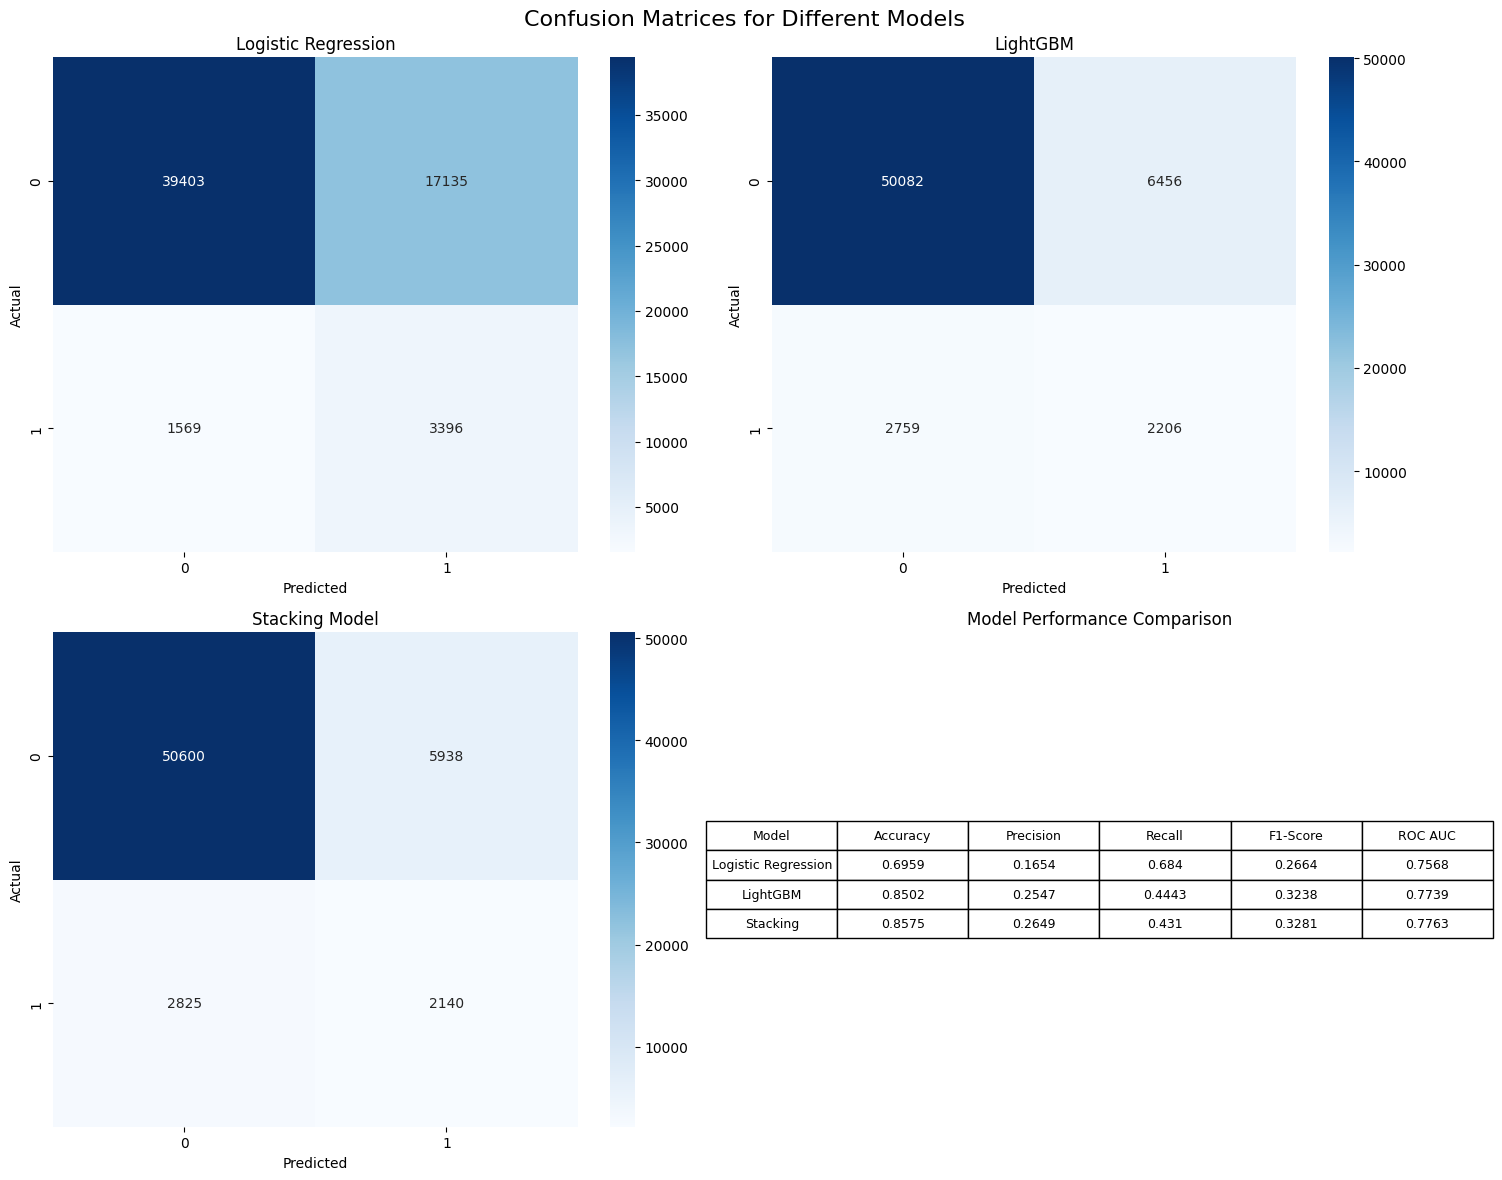

In [ ]:
# Tạo ma trận nhầm lẫn cho tất cả các mô hình đã huấn luyện
# Tạo subplot cho các ma trận nhầm lẫn
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

# 1. Logistic Regression
cm_lr = confusion_matrix(y_val, val_preds_lr_labels)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Logistic Regression')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. LightGBM
cm_lgb = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('LightGBM')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. Stacking Model
cm_stack = confusion_matrix(y_val, y_pred_stack_val)
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('Stacking Model')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 4. So sánh metrics
# Tính toán các metrics cho từng mô hình
models_metrics = {
    'Model': ['Logistic Regression', 'LightGBM', 'Stacking'],
    'Accuracy': [
        accuracy_score(y_val, val_preds_lr_labels),
        accuracy_score(y_val, y_pred_val),
        accuracy_score(y_val, y_pred_stack_val)
    ],
    'Precision': [
        precision_score(y_val, val_preds_lr_labels),
        precision_score(y_val, y_pred_val),
        precision_score(y_val, y_pred_stack_val)
    ],
    'Recall': [
        recall_score(y_val, val_preds_lr_labels),
        recall_score(y_val, y_pred_val),
        recall_score(y_val, y_pred_stack_val)
    ],
    'F1-Score': [
        f1_score(y_val, val_preds_lr_labels),
        f1_score(y_val, y_pred_val),
        f1_score(y_val, y_pred_stack_val)
    ],
    'ROC AUC': [
        roc_auc_score(y_val, val_probs_lr),
        roc_auc_score(y_val, val_probs),
        roc_auc_score(y_val, val_stack_probs)
    ]
}

metrics_df = pd.DataFrame(models_metrics)
print("Comparison of Model Performance:")
print(metrics_df.round(4))

# Tạo bảng so sánh trên subplot cuối
axes[1,1].axis('off')
table = axes[1,1].table(cellText=metrics_df.round(4).values,
                       colLabels=metrics_df.columns,
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
axes[1,1].set_title('Model Performance Comparison')

plt.tight_layout()
plt.show()


In [ ]:
# ---------- Tạo tệp submission với mô hình đã được tối ưu hóa ----------
final_model = pipe
test_predictions = final_model.predict_proba(X_test)[:, 1]
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
submission.to_csv('submission_tuned.csv', index=False)
print("\nĐã tạo tệp 'submission_tuned.csv' với mô hình đã được tối ưu hóa!")


Đã tạo tệp 'submission_tuned.csv' với mô hình đã được tối ưu hóa!
